# <center>MAF [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_moons import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Autoregressive Model:**
Autoregressive model whose conditionals are parameterized as single Gaussians:
\begin{equation*}
    p(x_i|x_{1:i-1})=\mathcal{N}(x_i;\mu(x_{1:i-1},\exp(\alpha(x_{1:i-1}))^2)
\end{equation*}

Comes back to:
\begin{equation*}
    x_i = u_i \exp(\alpha_i)+\mu_i \text{ where } u_i\sim\mathcal{N}(0,1)
\end{equation*}

By inverting, we have:
\begin{equation*}
    u_i = \exp(-\alpha_i)(x_i-\mu_i)
\end{equation*}

In MAF, implements $\mu$ and $\alpha$ using MADE. MADE is a feedforward NN that takes $x$ as input and output $\mu_i$ and $\alpha_i$ for all $i$ (with a single forward pass). The autoregressive property is enforced by multiplying the weights by a binary mask.

(Difference with IAF: the sens. MAF is made for density estimation when IAF is made for VI. MAF performs MADE on (x_i) when IAF performs MADE on (u_i)).


To invert, we have to use the following algorithm:

Given $z'$,

For all $i=1:D$:

- $z_i=(z_i'-\mu(z_{1:i-1}))e^{-s(z_{1:i-1})}$

(and the first value of $\mu$ and $s$ are taken arbitrarily.)

In [3]:
## https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib/made.py

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)


class ARMLP(nn.Module):
    """ a 4-layer auto-regressive MLP, wrapper around MADE net """

    def __init__(self, nin, nh, nout, n_layers=3):
        super().__init__()
        self.net = MADE(nin, [nh for i in range(3)], nout, num_masks=1, natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)

In [4]:
class MAF(BaseNormalizingFlow):
    """
        Masked Autoregressive Flow
    """
    def __init__(self, net):
        """
            net must be a MADE net (i.e. with mask on the rights connections)
        """
        super().__init__()
        self.net = net

    def forward(self, x):
        output = self.net(x)
        alpha, mu = output[:,:output.size(1)//2], output[:,output.size(1)//2:]

        z = x*torch.exp(alpha)+mu
        log_det = torch.sum(alpha, dim=1)
        
        return z, log_det

    def backward(self, z):
        x = torch.zeros(z.size(),device=device)
        log_det = torch.zeros(z.size(0),device=device)

        for i in range(z.size(1)):
            output = self.net(x)
            alpha, mu = output[:,:output.size(1)//2], output[:,output.size(1)//2:]
            x[:,i] = (z[:,i]-mu[:,i])*torch.exp(-alpha[:,i])
            log_det -= alpha[:,i]
            
        return x, log_det

## Moons

In [5]:
d = 2

nets = [ARMLP(d,24,2*d,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(MAF(nets[i]))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  6860


0 3.627025604248047


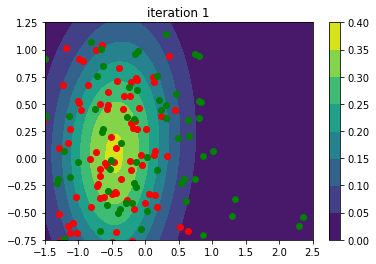

1000 1.6636580228805542


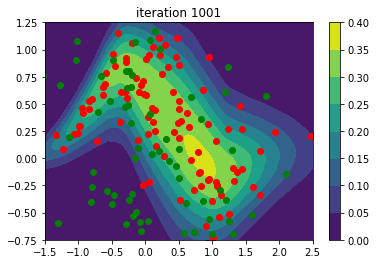

2000 1.4243648052215576


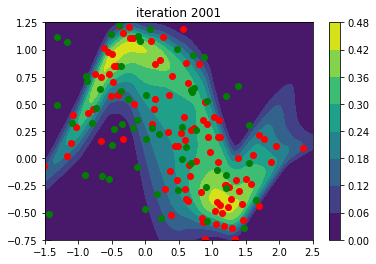

3000 1.2516405582427979


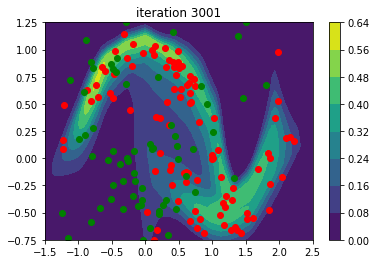

4000 1.1259708404541016


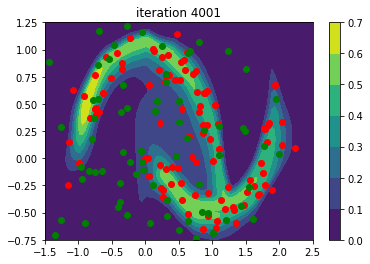

5000 1.1131103038787842


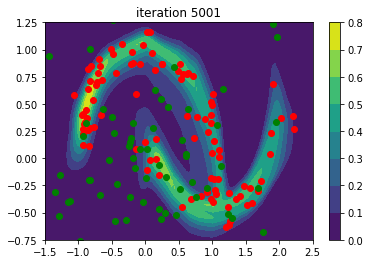

6000 1.1529889106750488


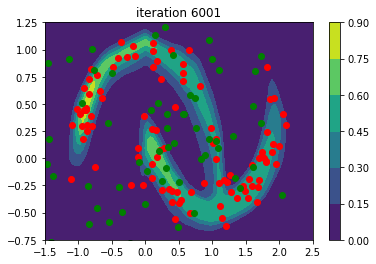

7000 1.050704002380371


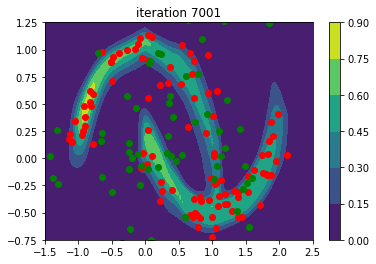

8000 1.1190292835235596


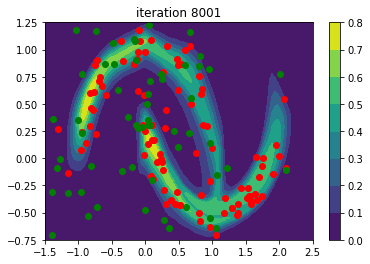

9000 1.1924691200256348


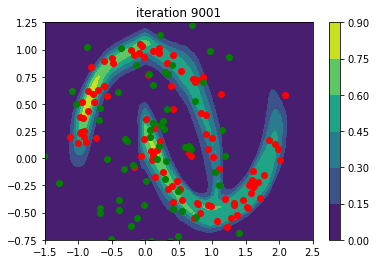

10000 1.098548173904419


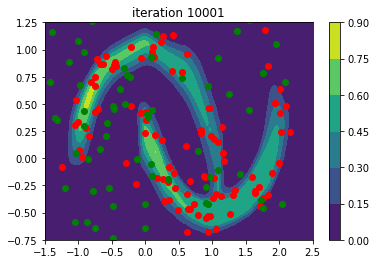

In [6]:
train_loss = train_moons(model, optimizer, base_distr="normal")

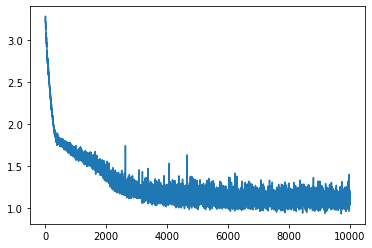

In [ ]:
plt.plot(train_loss)
plt.show()

## MNIST

In [ ]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw




Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


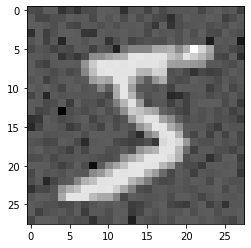

In [ ]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [ ]:
def loss(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

In [ ]:
def log_likelihood(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [ ]:
def val():
    d = 28*28
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    model.eval()
    zs,log_det = model.backward(z_random.reshape(-1,28*28))
    gen_imgs = zs[-1].view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [ ]:
d = 784

nets = [ARMLP(d,24,2*d,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(MAF(nets[i]))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))
    
model = NormalizingFlows(flows).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  304040


0 3653.963747459688


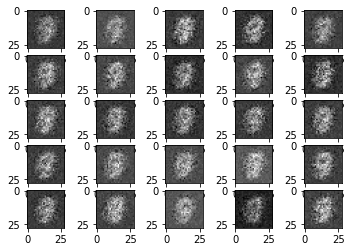

1 3374.836238381197
2 3135.1373965135263
3 2928.4634257562634
4 2745.9901084005196
5 2588.8388099263725
6 2450.7689175148253
7 2326.640028443164
8 2215.1694466076424
9 2114.794810996635
10 2024.4900068921575
11 1943.571664903718
12 1871.4456753273255
13 1807.1340269564566
14 1750.0115058427173
15 1699.9148750874533
16 1655.9317340647488
17 1617.7398202729378
18 1584.5600466209687
19 1556.771768858692
20 1532.9094771850846
21 1513.6930970149253
22 1497.4023031466552
23 1484.617644027352
24 1474.5004101978946
25 1466.9448918909916
26 1461.3500357101213
27 1457.1513481872169
28 1453.9791369082322
29 1451.7525515037812
30 1450.2540389917044
31 1448.2415748059368
32 1446.8766538054704
33 1445.6578129685001
34 1444.579820189649
35 1443.2835630892691
36 1442.1995672620435
37 1440.8094308035713
38 1439.664475040395
39 1438.1381003048375
40 1437.5390651027785
41 1435.8817888272088
42 1435.2653871060434
43 1433.8887694791945
44 1432.6318205811067
45 1431.8802341875999
46 1431.1416760019656
47 14

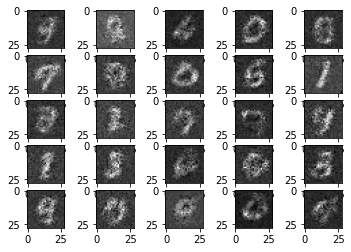

51 1426.4105885715119
52 1425.7578104177771
53 1425.1216369498768
54 1424.4271211603811
55 1423.652075143257
56 1423.0186699905883
57 1422.049714891641
58 1421.3319042344083
59 1420.835145214219
60 1420.1039609604045
61 1419.564263642724
62 1419.0626803725513
63 1418.535512830657
64 1417.5732926814032
65 1417.119763990455
66 1416.5887216921808
67 1415.9254754235242
68 1415.3000532528486
69 1415.1670650652984
70 1414.374501307636
71 1414.2684250691298
72 1413.646300098281
73 1413.1286772054905
74 1412.6350542731377
75 1412.3163286872002
76 1411.9240329636693
77 1411.5345789537246
78 1411.058616654451
79 1410.669401839852
80 1410.4773956494037
81 1409.665119748634
82 1409.3068152714386
83 1409.0782103711354
84 1408.8973058119004
85 1408.4198039691332
86 1408.2184288171309
87 1407.529358300573
88 1407.3628671479378
89 1406.6929994107309
90 1406.8939018981544
91 1406.0845824935034
92 1406.1447045950492
93 1405.491572723714
94 1404.9387235661814
95 1404.8625087453358
96 1404.8074547741205
9

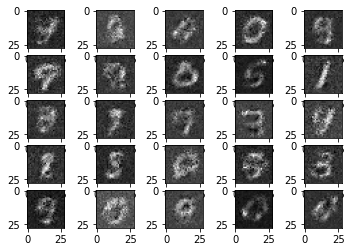

In [ ]:
num_epochs = 101

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()

    train_batch = []

    for n_batch, (data,_) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1,28*28)
        z, log_det = model(data)

        l = loss(z[-1], log_det)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_batch.append(l.item())


    print(epoch, np.mean(train_batch))
    train_losses.append(np.mean(train_batch))

    if epoch % 50 == 0:
        val()


In [ ]:
test_batch = []

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det)

    test_batch.append(l.mean().item())


In [ ]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = log_likelihood / (np.prod(784) * np.log(2.))
print(bpd)

-2.5964732745463346


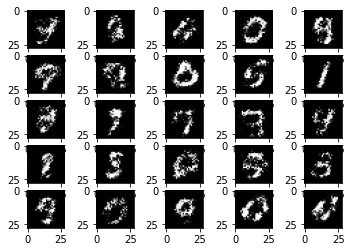

In [ ]:
d = 28*28
torch.manual_seed(42)
r,c = 5,5
z_random = torch.randn(r,c,d,device=device)
model.eval()
zs,log_det = model.backward(z_random.reshape(-1,28*28))
gen_imgs = zs[-1].view(-1,28,28)
gen_imgs = gen_imgs.detach().cpu()
lambd = 1e-6
gen_imgs = (torch.sigmoid(gen_imgs)-lambd)/(1-2*lambd)

cpt = 0
fig,ax = plt.subplots(r,c)
for i in range(r):
    for j in range(c):
        ax[i,j].imshow(gen_imgs[cpt],"gray")
        cpt += 1
plt.show()

## References

<a id="reference1"></a>

[1] Papamakarios, G., Pavlakou, T., & Murray, I. Masked Autoregressive Flow for Density Estimation. arXiv preprint arXiv:1705.07057. (2017). [link](https://arxiv.org/abs/1705.07057 )